# [IDPP CLEF Challlenge](http://brainteaser.dei.unipd.it/challenges/idpp2023/)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
import lightgbm

# machine learning
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import r_regression
from sklearn import preprocessing

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")

%config InlineBackend.figure_format = 'retina'

In [3]:
DATASET = "datasetB"
DATASET_DIR = f"../data/{DATASET}_train"
ID_FEAT = "patient_id"

pd.set_option('display.max_rows', None)

# Load and Merge data

In [4]:
def filenames_in_folder(dir_path):
    file_names = []
    for _, __, f_names in os.walk(dir_path):
        for file_name in f_names:
            file_names.append(file_name)
        break
    return file_names


def read_dfs(dir_path):
    file_names = filenames_in_folder(dir_path)
    dfs = {file_name.removesuffix(".csv"): pd.read_csv(os.path.join(dir_path, file_name)) for file_name in file_names if file_name.endswith("csv")}
    return dfs

dfs = read_dfs(DATASET_DIR)


In [5]:
def dfs_unique_patients(dfs):
    out = {}
    for name, df in dfs.items():
        out[name] = len(df[ID_FEAT].unique())
    return pd.DataFrame.from_dict(out, orient="index", columns=["Unique patients"])

In [6]:
def merge_dfs_complete(dfs, dataset):

    def group_ts_column_to_list(orig_df, id_feat, other_feature):
        unique_ids = orig_df[id_feat].unique()
        grouped_ts_column_as_list = orig_df.groupby(id_feat)[other_feature].apply(lambda x: x.values).values.tolist()
        new_df = pd.DataFrame.from_dict({id_feat: unique_ids,
                                         other_feature: grouped_ts_column_as_list})
        new_df = new_df.set_index(id_feat)
        return new_df

    def group_ts_column_select_first(orig_df, id_feat, other_feature):
        unique_ids = orig_df[id_feat].unique()
        first_values = orig_df.groupby(id_feat)[other_feature].apply(lambda x: x.values[0]).values

        new_df = pd.DataFrame.from_dict({id_feat: unique_ids,
                                         other_feature: first_values})
        new_df = new_df.set_index(id_feat)
        return new_df

    def group_ts_df_by_id(orig_df, id_feat, time_series_feats, one_occurrence_feats, sort_by_this_feat):
        orig_df = orig_df.sort_values(by=[ID_FEAT, sort_by_this_feat])
        ts_dfs = [group_ts_column_to_list(orig_df, id_feat, ts_feat) for ts_feat in time_series_feats]
        oo_dfs = [group_ts_column_select_first(orig_df, id_feat, oo_feat) for oo_feat in one_occurrence_feats]

        out_df = pd.concat([*oo_dfs, *ts_dfs], axis=1)
        out_df.reset_index(names=id_feat, inplace=True)
        return out_df

    merged_df = pd.merge(dfs[f"{dataset}_train-static-vars"], dfs[f"{dataset}_train-outcomes"],
                         on="patient_id", how="outer")

    relapses_df = dfs[f"{dataset}_train-relapses"]
    ts_feats = ["delta_relapse_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_relapse_time0"
    relapses_df = group_ts_df_by_id(relapses_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    ms_type_df = dfs[f"{dataset}_train-ms-type"]
    ts_feats = ["multiple_sclerosis_type", "delta_observation_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_observation_time0"
    ms_type_df = group_ts_df_by_id(ms_type_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    mri_df = dfs[f"{dataset}_train-mri"]
    ts_feats = ["mri_area_label", "lesions_T1", "lesions_T1_gadolinium", "number_of_lesions_T1_gadolinium",
                "new_or_enlarged_lesions_T2", "number_of_new_or_enlarged_lesions_T2", "lesions_T2", "number_of_total_lesions_T2", "delta_mri_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_mri_time0"
    mri_df = group_ts_df_by_id(mri_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    evoked_p_df = dfs[f"{dataset}_train-evoked-potentials"]
    ts_feats = ["altered_potential", "potential_value", "location", "delta_evoked_potential_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_evoked_potential_time0"
    evoked_p_df = group_ts_df_by_id(evoked_p_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)


    edss_df = dfs[f"{dataset}_train-edss"]
    ts_feats = ["edss_as_evaluated_by_clinician", "delta_edss_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_edss_time0"
    edss_df = group_ts_df_by_id(edss_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    grouped_dfs = [edss_df, relapses_df, ms_type_df, evoked_p_df, mri_df]
    for df in grouped_dfs:
        merged_df = pd.merge(merged_df, df, on=[ID_FEAT, "centre"], how="outer")

    return merged_df

dfs = read_dfs(DATASET_DIR)
merged_df = merge_dfs_complete(dfs, DATASET)

In [7]:
dfs["merged_df"] = merged_df
unique_patients = dfs_unique_patients(dfs)
unique_patients

,Unique patients
datasetB_train-edss,510
datasetB_train-evoked-potentials,183
datasetB_train-mri,303
datasetB_train-ms-type,218
datasetB_train-outcomes,510
datasetB_train-relapses,284
datasetB_train-static-vars,510
merged_df,510


In [8]:
merged_df.columns.to_series().groupby(merged_df.dtypes).groups

{bool: ['ms_in_pediatric_age', 'spinal_cord_symptom', 'brainstem_symptom', 'eye_symptom', 'supratentorial_symptom'], int64: ['age_at_onset', 'time_since_onset', 'outcome_occurred'], float64: ['diagnostic_delay', 'outcome_time'], object: ['patient_id', 'sex', 'residence_classification', 'ethnicity', 'other_symptoms', 'centre', 'edss_as_evaluated_by_clinician', 'delta_edss_time0', 'delta_relapse_time0', 'multiple_sclerosis_type', 'delta_observation_time0', 'altered_potential', 'potential_value', 'location', 'delta_evoked_potential_time0', 'mri_area_label', 'lesions_T1', 'lesions_T1_gadolinium', 'number_of_lesions_T1_gadolinium', 'new_or_enlarged_lesions_T2', 'number_of_new_or_enlarged_lesions_T2', 'lesions_T2', 'number_of_total_lesions_T2', 'delta_mri_time0']}

# Preprocessing

In [9]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_feature(df, feat):
    unique_values = df[feat].unique()
    enc = OneHotEncoder()
    out = enc.fit_transform(df[feat])
    return out

def preprocess(merge_df):
    merge_df = merge_df.copy()
    sex_map = {"male": 1, "female": 2}
    merged_df["sex"] = merged_df["sex"].map(sex_map)

    residence_map = {"Towns": 1, "Rural Area": 2, "Cities": 3}
    merged_df["residence_classification"] = merged_df["residence_classification"].map(residence_map)

    ethnicity_map = {"Caucasian": 1, np.nan: 0}
    merged_df["ethnicity"] = merged_df["ethnicity"].map(ethnicity_map)

    centre_map = {"pavia": 1, "turin": 2}
    merged_df["ethnicity"] = merged_df["ethnicity"].map(centre_map)
    bool_features = ['ms_in_pediatric_age', 'spinal_cord_symptom', 'brainstem_symptom',
                     'eye_symptom', 'supratentorial_symptom']
    for bool_feat in bool_features:
        merge_df[bool_feat] = merge_df[bool_feat].astype(np.int64)


    return merge_df

# one_hot_feature(merged_df, "sex")
# df = preprocess(merged_df)

# Analysing dataset

In [10]:
missing_values = ((merged_df.isnull().sum() * 100 / len(merged_df)).sort_values(ascending=False))
print("Missing value rate:\n", missing_values.to_string())

Missing value rate:
 altered_potential                       64.117647
potential_value                         64.117647
location                                64.117647
delta_evoked_potential_time0            64.117647
delta_observation_time0                 57.254902
multiple_sclerosis_type                 57.254902
delta_relapse_time0                     44.313725
lesions_T1_gadolinium                   40.588235
mri_area_label                          40.588235
lesions_T1                              40.588235
delta_mri_time0                         40.588235
new_or_enlarged_lesions_T2              40.588235
number_of_new_or_enlarged_lesions_T2    40.588235
lesions_T2                              40.588235
number_of_total_lesions_T2              40.588235
number_of_lesions_T1_gadolinium         40.588235
ethnicity                                3.725490
residence_classification                 3.137255
diagnostic_delay                         1.764706
patient_id                   

In [11]:
static_values = ['sex', 'residence_classification', 'ethnicity',
       'ms_in_pediatric_age', 'age_at_onset', 'diagnostic_delay',
       'spinal_cord_symptom', 'brainstem_symptom', 'eye_symptom',
       'supratentorial_symptom', 'other_symptoms', 'centre',
       'time_since_onset', 'outcome_occurred', 'outcome_time']
# sns.pairplot(merged_df[static_values])


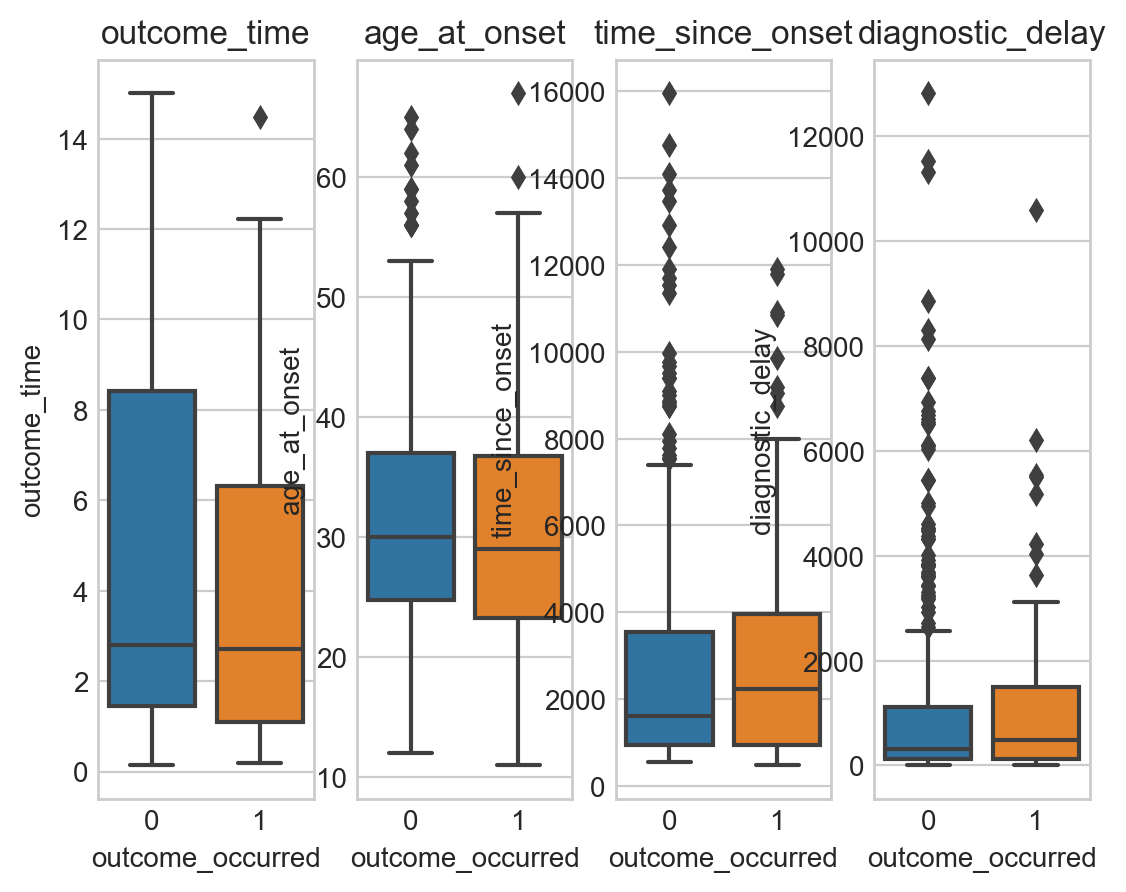

In [12]:
fig, axes = plt.subplots(1, 4)
for ax, feat in zip(axes.flat, ["outcome_time","age_at_onset", "time_since_onset","diagnostic_delay"]):
    sns.boxplot(merged_df, x="outcome_occurred", y=feat, ax=ax)
    ax.set(title=f"{feat}")

In [13]:
# merged_df = merged_df.replace({np.nan: None})
# def calc_len(x):
#     if x is None:
#         return 0
#     else:
#         return len(x)
#
# plot_df = pd.DataFrame(merged_df[[ID_FEAT, "outcome_occurred", "delta_evoked_potential_time0"]])
# plot_df["delta_evoked_potential_time0_na"] = plot_df["delta_evoked_potential_time0"].isna()
# plot_df["delta_evoked_potential_time0_len"] = plot_df["delta_evoked_potential_time0"].apply(calc_len)
#
# sns.countplot(x='delta_evoked_potential_time0_len', data=plot_df)

<Axes: >

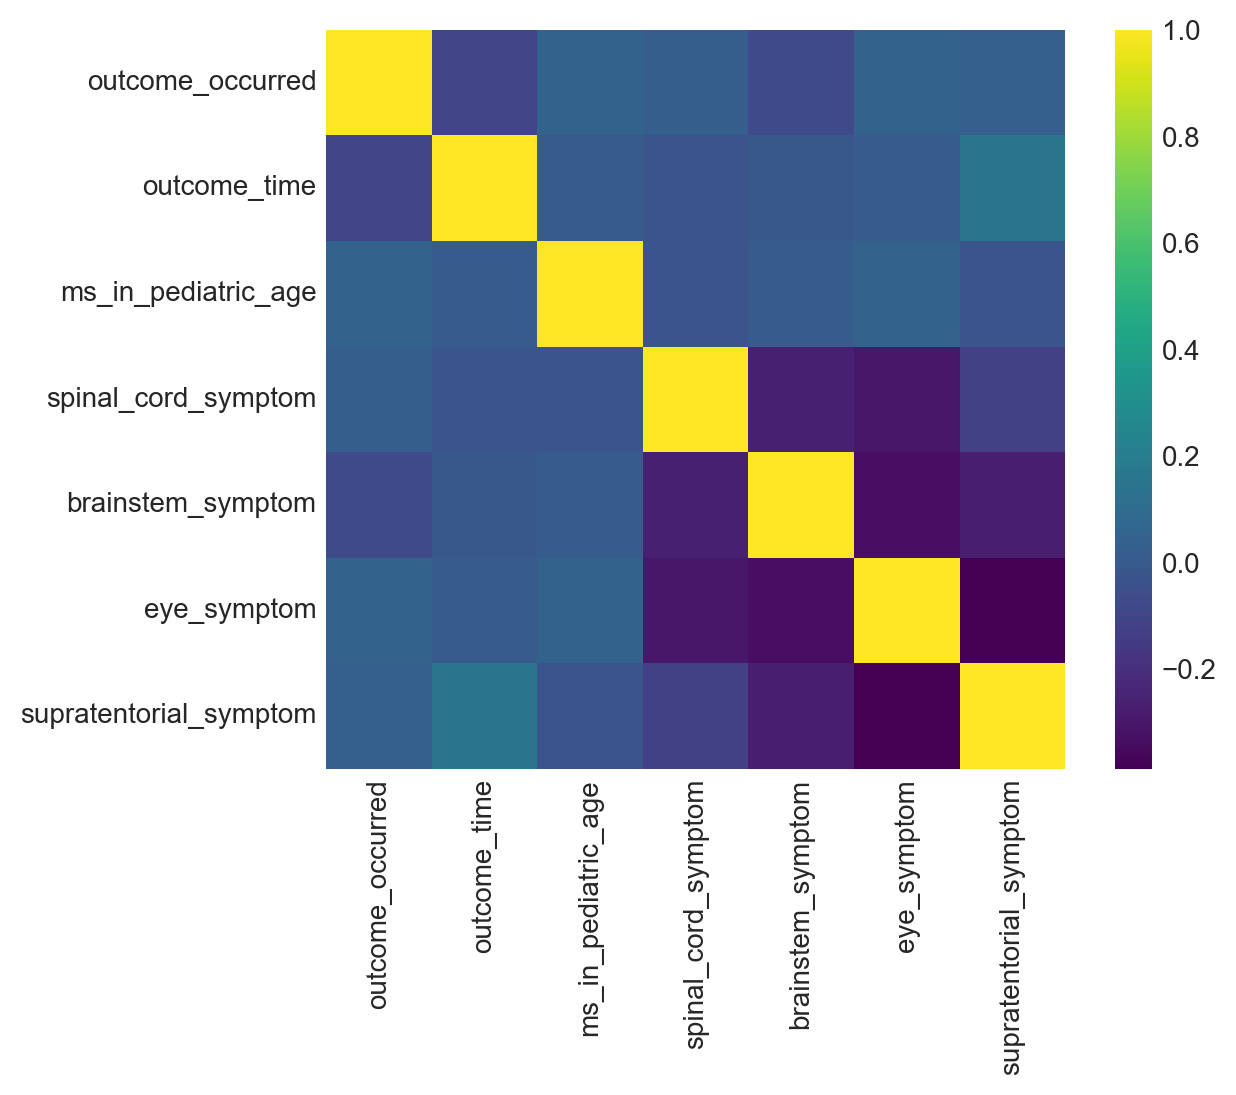

In [14]:
values = ['outcome_occurred', "outcome_time",'ms_in_pediatric_age', 'spinal_cord_symptom', 'brainstem_symptom', 'eye_symptom', 'supratentorial_symptom']
corr_mat = merged_df[values].corr()
f, ax = plt.subplots()
sns.heatmap(corr_mat,  vmax=1, cmap="viridis", square=True)

In [15]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

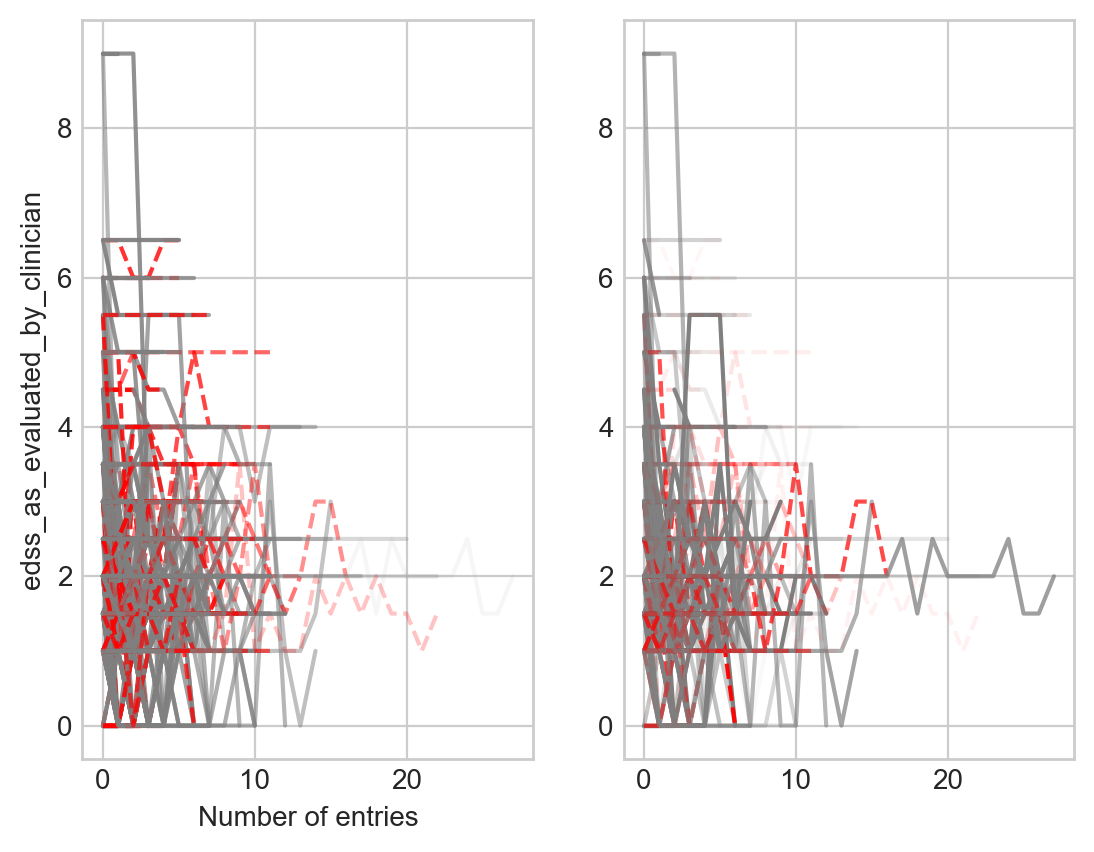

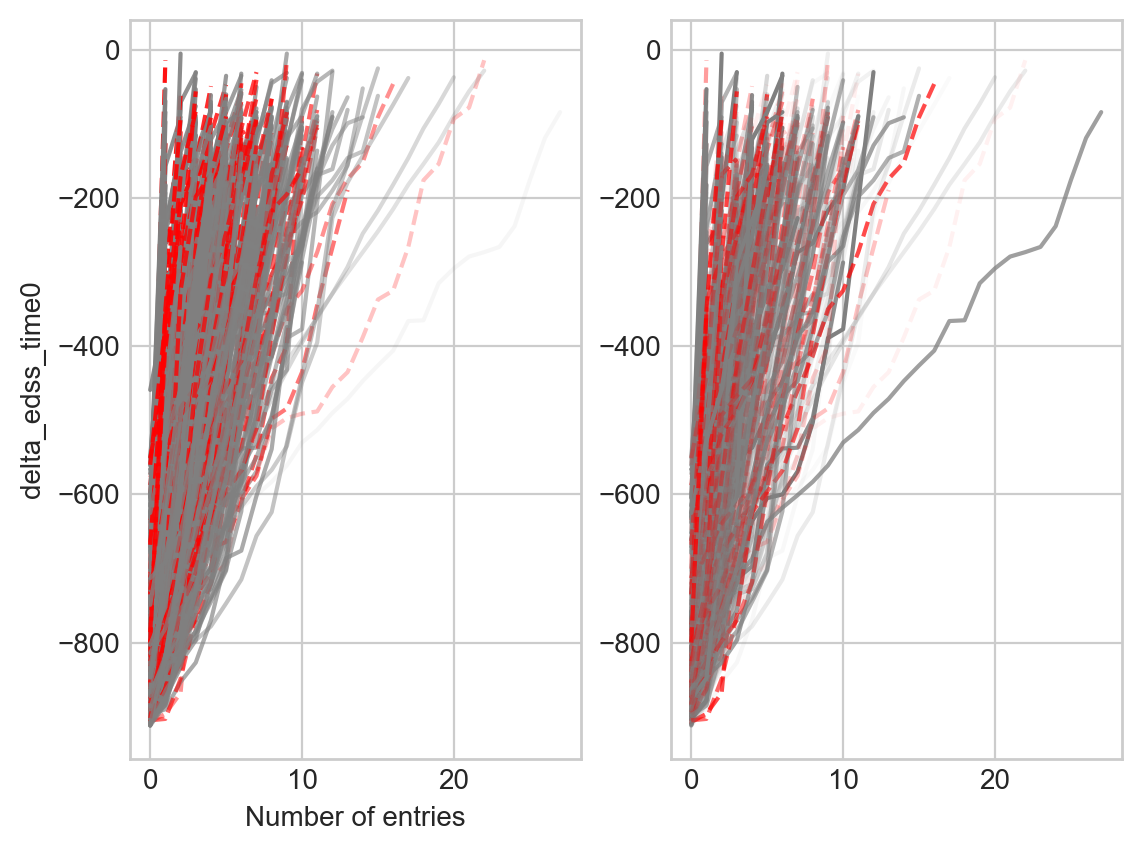

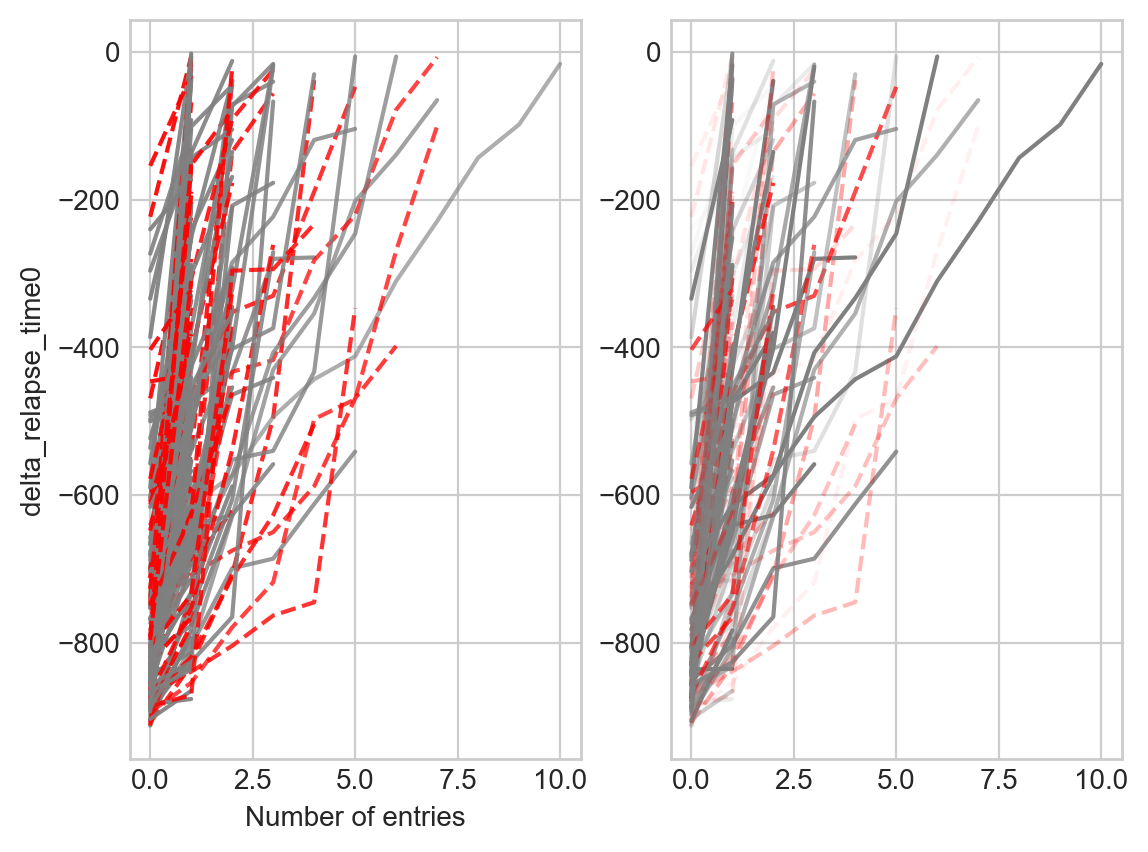

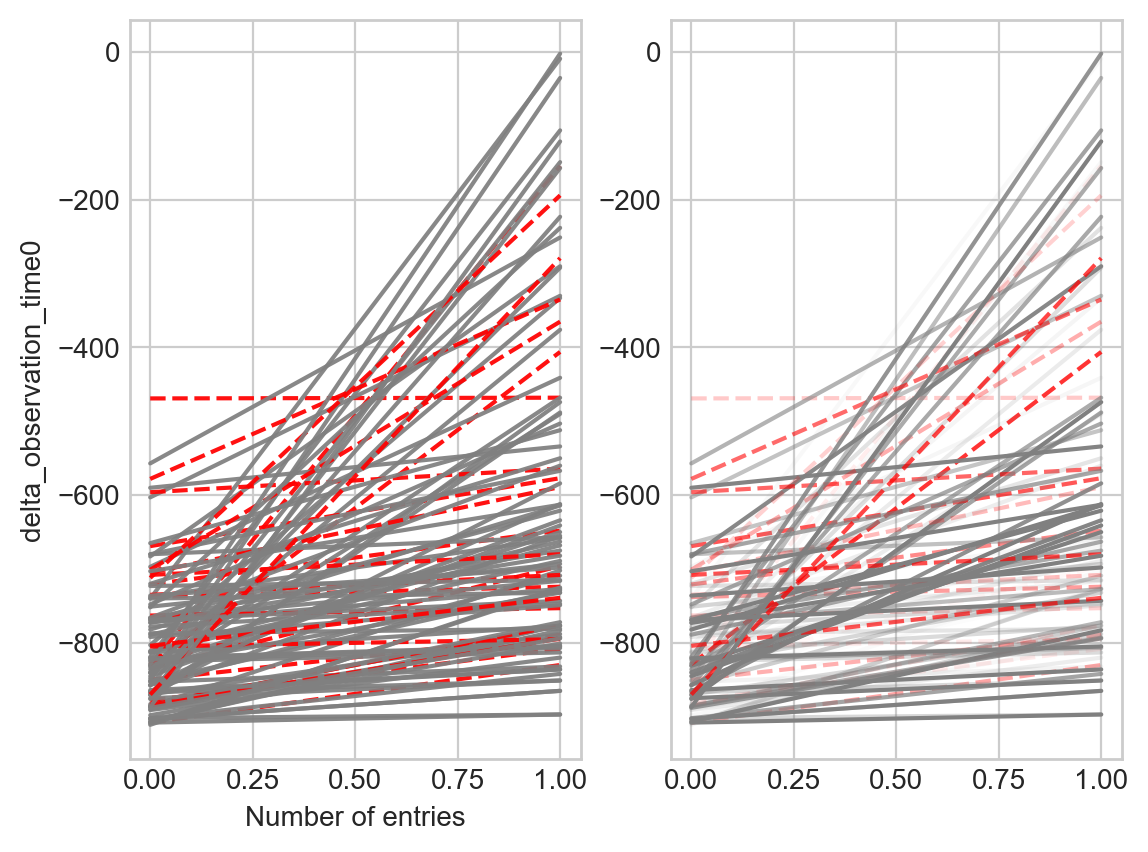

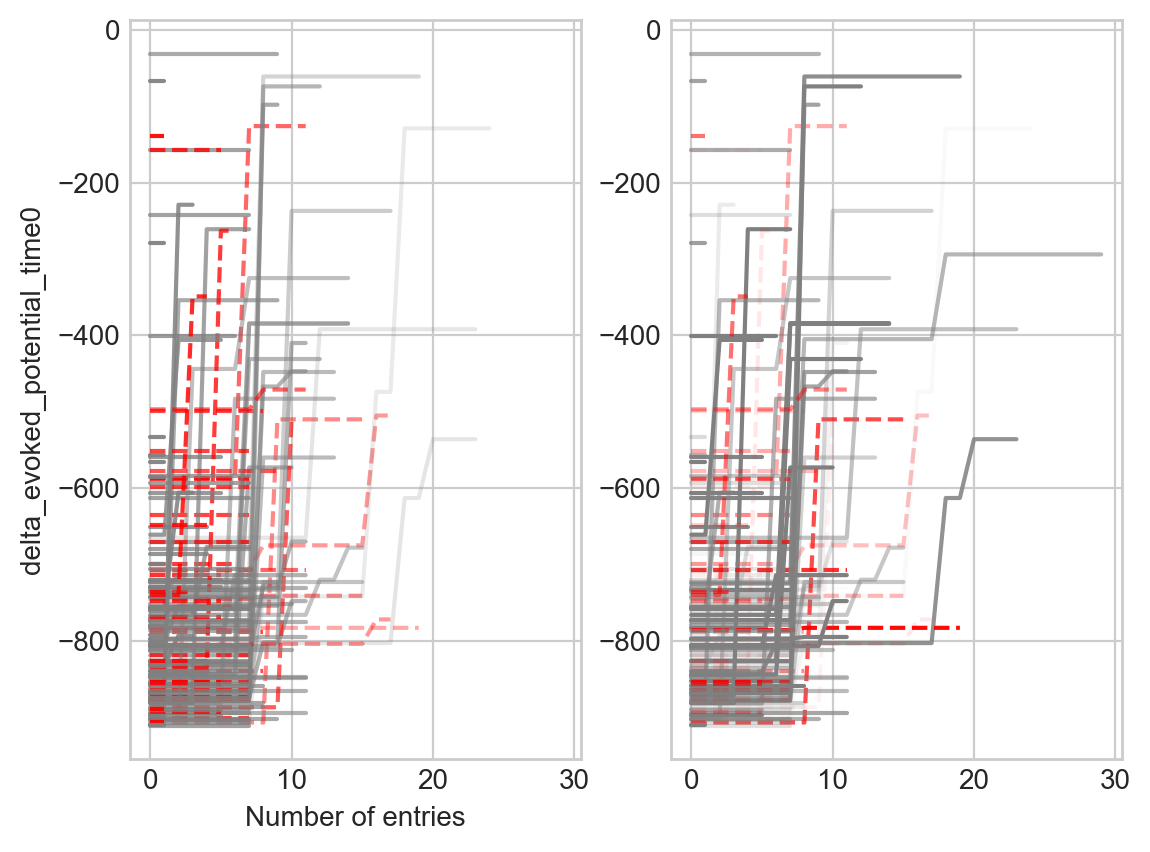

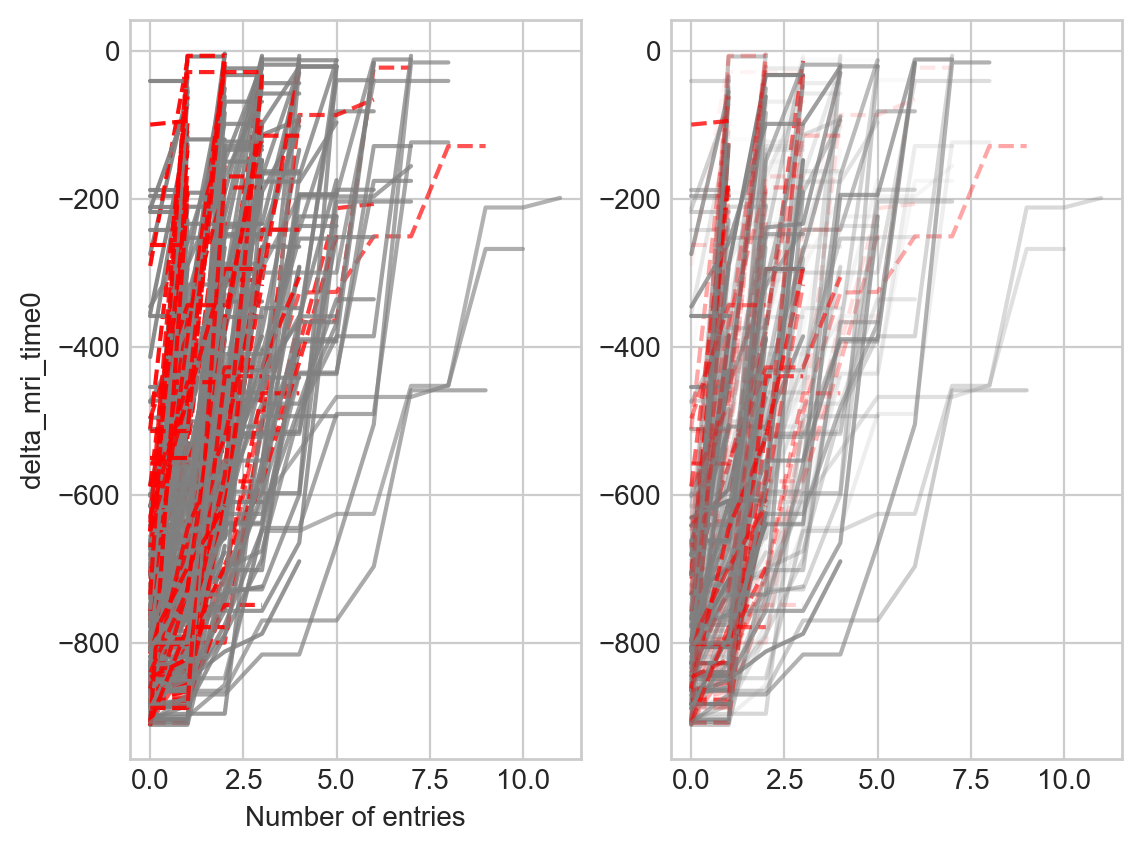

In [16]:
merged_df = merged_df.replace({np.nan: None})
outcome, o_time = merged_df["outcome_occurred"], merged_df["outcome_time"]
ts_feats = ['edss_as_evaluated_by_clinician', 'delta_edss_time0', 'delta_relapse_time0', 'delta_observation_time0', 'delta_evoked_potential_time0', 'delta_mri_time0']
for feat in ts_feats:
    fig, axes = plt.subplots(1, 2)
    axes = axes.flat
    X = merged_df[feat]
    for x, out, ot in zip(X, outcome, o_time):
        if x is None:
            continue
        else:
            alpha = np.interp(len(x), [0, 30], [1, 0])
            plot_params = dict(color="r" if out == 1 else "0.5",
                               linestyle="--" if out == 1 else "-")
            axes[0].plot(x, alpha=alpha, **plot_params)
            axes[0].set(xlabel="Number of entries", ylabel=f"{feat}")

            alpha = np.interp(ot, [0, 15], [0, 1])
            axes[1].plot(x, alpha=alpha, **plot_params)

    plt.show()
